In [286]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import json
import os
import pickle
import re
import seaborn as sns

from src.utils.additional_plotting_functions import loss_archetype_plot, NMI_archetypes, plot_NMI_stability


my_pallette = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSOAA" : "#073B4C"}

In [288]:


def load_result_obj(path: str):
    file = open(path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def load_analyses(analysis_dir: str):
    """
    Function that loads results from a given analysis.
    The format is a nested dictionary on the form results[AA_method][n_archetypes][repetition_num]
    The result objects saved have all matrices and parameters inside them. E
    """
    folder = f'C:/Users/aejew/Downloads/AA_results/AA_results/{analysis_dir}'
    results = {'RBOAA': {}, 'OAA': {}, 'CAA': {}} if 'OSM' not in analysis_dir else {'TSAA': {}}

    for method in results.keys():
        method_dir = f'{folder}/{method}_objects'
        all_files = os.listdir(method_dir)
        for file in all_files:
            obj = load_result_obj(f'{method_dir}/{file}')
            K = re.sub('[^0-9]', '', file.split('_')[1])
            rep = int(file.split('_')[-1][-1])
            if f'K{K}' not in results[method].keys():
                results[method][f'K{K}'] = {}
            
            results[method][f'K{K}'][rep] = obj
    return results


In [289]:
GB_res= load_analyses("ESS8_GB_results")


In [387]:
def loss_archetype_plot(K_list, results_path: str = 'synthetic_results/1000_complex_results.json',results_path2: str = None):
    """
    A plot over the final loss obtained as a function of the number of archetypes.
    Parameters:
        - results_path (str): Path to a .json results file created by running ResultMaker.get_results()
    """

    with open(f'{results_path}', 'r') as f:
        result = json.load(f)
        df_res = pd.DataFrame(result)


    if results_path2:
        with open(f'{results_path2}', 'r') as f:
            result2 = json.load(f)
            df_res2 = pd.DataFrame(result2)

        df_res2.method = df_res2.method.replace({'CAA': 'TSAA'})    
        df_res = pd.concat([df_res,df_res2])

    df_res.method = df_res.method.replace({'OAA': 'OAA', 'RBOAA': 'RBOAA', 'CAA': 'AA','TSAA': 'TSAA'})  

    methods = df_res['method'].unique()

    methods_colors = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSAA" : "#073B4C"}
    #methods_colors = dict(zip(methods.tolist(), ["#EF476F", "#FFD166", "#06D6A0", "#073B4C"]))
    fig, ax = plt.subplots(figsize = (15,5), layout='constrained')


    def add_curve(analysis_archetypes, losses, is_min: bool, method: str):
        if is_min:
            plt.plot(analysis_archetypes, losses,"-o",c=methods_colors[method],label=f'{method}')
        else:
            # plt.scatter(analysis_archetypes, losses)
            plt.plot(analysis_archetypes, losses, alpha=0.3, c=methods_colors[method])

    ax.set_xlabel('Number of archetypes', fontsize=30)
    
    ax.set_ylabel('Cross entropy loss', fontsize=30)
    ax2 = ax.twinx()
    ax2.set_ylabel('SSE',fontsize=30)
    ax.set_ylim(0,60000)

    # TODO: Automatic set of ax2 ylim to avoid the two plots starting the same place something likemin = min(min_loss_AA, min_loss_TSOAA)*0.9 and max  = max(max_loss_AA, max_loss_TSOAA)*1.1
    #ax2.set_ylim((np.min(df_res[df_res.method=='AA'].loss[-1])-1000,np.max(df_res[df_res.method=='TSAA'].loss[0])+1000))
    #ax.set_ylim((np.min(df_res[df_res.method=='RBOAA'].loss[-1])-1000,np.max(df_res[df_res.method=='OAA'].loss[0])+1000))
    
    for method in methods:
        df_losses = df_res.loc[df_res['method'] == method][['n_archetypes', 'loss']]
        analysis_archetypes = K_list #df_losses['n_archetypes'].unique().tolist()

        all_losses = [df_losses.loc[df_losses['n_archetypes'] == e]['loss'].values for e in analysis_archetypes]
        analysis_archetypes = list(map(str, analysis_archetypes))
        losses = np.array([[e[-1] for e in loss] for loss in all_losses]) # n_archetypes x n_repeats array with losses at final iter
        
        tmp = losses[losses == np.min(losses, axis=1)[:, None]]
        _, idx = np.unique(losses[losses == np.min(losses, axis=1)[:, None]], return_index=True)
        min_losses = tmp[np.sort(idx)]
        print(str(method)+str(np.argmin(losses,axis=1)))

        
        if method in ['AA','TSAA']:
            
            ax2.plot(analysis_archetypes, min_losses,"-o",c=methods_colors[method],label=f'{method}')
            # = add_curve(analysis_archetypes, min_losses, is_min=True, method=method)

            for rep in range(losses.shape[1]):
                ax2.plot(analysis_archetypes, losses[:, rep], alpha=0.3, c=methods_colors[method])
        
        else:
            ax.plot(analysis_archetypes, min_losses,"-o",c=methods_colors[method],label=f'{method}')
            #ax.add_curve(analysis_archetypes, min_losses, is_min=True, method=method)

            for rep in range(losses.shape[1]):
                ax.plot(analysis_archetypes, losses[:, rep], alpha=0.3, c=methods_colors[method])
    

    # Not sure what diff between minor and major is
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)

    ax2.tick_params(axis='both', which='major', labelsize=25,colors = "#073B4C")
    ax2.tick_params(axis='both', which='minor', labelsize=25)

    ax.set_ylim(0,60000)

    ax2.spines['right'].set_color(methods_colors["AA"])
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0,fontsize=30)

RBOAA[5 6 2 4 0 4 7 3 2 7 6 7 7]
OAA[5 1 6 2 2 2 7 4 3 3 2 6 6]
AA[9 2 4 0 2 3 8 6 0 8 3 8 2]
TSAA[9 8 4 0 5 5 4 2 1 3 6 7 6]


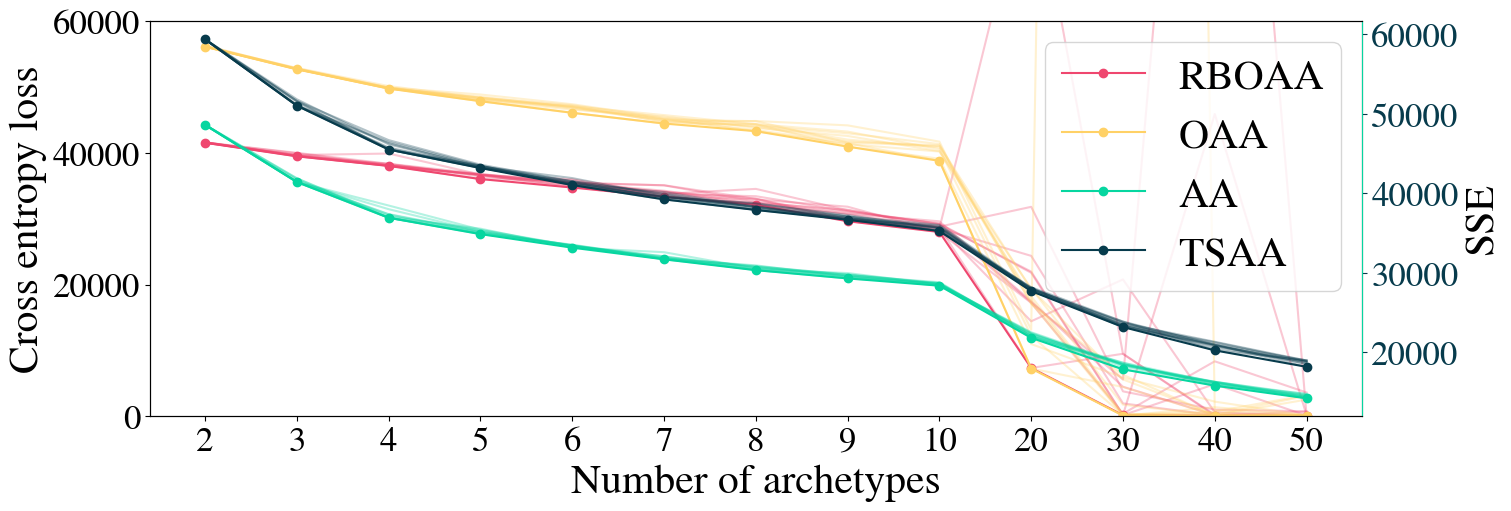

In [388]:
K_list = [2,3,4,5,6,7,8,9,10,20,30,40,50]
#K_list = [2,3,4,5,6,7,8,9,10]
loss_archetype_plot(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/ESS8_GB_All_AA_results.json', results_path2 = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_OSM_results/ESS8_GB_OSM_All_AA_results.json")

plt.savefig("Plots_for_paper/Error_K_GB.png",dpi=1000)

In [12]:

def calcMI(z1,z2):
    eps = 10e-16
    P = z1@z2.T
    PXY = P/P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0),np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY>0)
    MI = np.sum(PXY*np.log(eps+PXY/(eps+PXPY)))
    return MI
    
def calcNMI(z1,z2):
    NMI=(2*calcMI(z1,z2))/(calcMI(z1,z1)+calcMI(z2,z2))
    #NMI = NMI.reshape((z1.shape[0], z1.shape[0]))
    
    return NMI


def load_result_obj(path: str):
    file = open(path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file


import itertools
#TODO : Lots of room for improvement with dataloader
def plot_NMI_stability(folder_path, K_list, repetitions= 10,folder_path2 = ''):
    methods = ["CAA", "OAA", "RBOAA","TSAA"]


    test = itertools.combinations(range(repetitions), 2)
    t = list(test)
    calcIDX = np.array(t)

    NMI_RBOAA_complex_large = np.zeros((len(K_list),len(calcIDX)))
    NMI_OAA_complex_large = np.zeros((len(K_list),len(calcIDX)))
    NMI_AA_complex_large = np.zeros((len(K_list),len(calcIDX)))
    NMI_TSAA_complex_large = np.zeros((len(K_list),len(calcIDX)))

    for method in methods:
        i = 0
        for K in K_list:

            for j in range(len(calcIDX)):
                
                filename1 = folder_path+str(method)+"_K="+str(K)+"_rep="+str(calcIDX[j,0]) #+".npy"
                filename2 = folder_path+str(method)+"_K="+str(K)+"_rep="+str(calcIDX[j,1]) #+".npy"
                file1 = load_result_obj(filename1)
                file2 = load_result_obj(filename2)
                file1 = file1.A
                file2 = file2.A

                if method == "TSOAA":
                    
                    NMI_TSAA_complex_large[i,j] = calcNMI(file1,file2)




                if method == "RBOAA":
                    NMI_RBOAA_complex_large[i,j] = calcNMI(file1,file2)

                elif method == "OAA":
                    NMI_OAA_complex_large[i,j] = calcNMI(file1,file2)

                elif method == "CAA":
                    NMI_AA_complex_large[i,j] = calcNMI(file1,file2)
                elif method == "TSAA":
                    NMI_TSAA_complex_large[i,j] = calcNMI(file1,file2)
            
            i += 1

    df1 = pd.DataFrame(NMI_RBOAA_complex_large.T, columns = K_list)
    df2 = pd.DataFrame(NMI_OAA_complex_large.T, columns = K_list)
    df3 = pd.DataFrame(NMI_AA_complex_large.T, columns = K_list)

    df1['Method'] = 'RBOAA'
    df2['Method'] = 'OAA'
    df3['Method'] = 'AA'

    df1 = df1.melt(id_vars='Method', var_name='Archetypes', value_name='NMI')
    df2 = df2.melt(id_vars='Method', var_name='Archetypes', value_name='NMI')
    df3 = df3.melt(id_vars='Method', var_name='Archetypes', value_name='NMI')


    df = pd.concat([df1,df2,df3])
    df.Method = df.Method.replace({'OAA': 'OAA', 'RBOAA': 'RBOAA', 'AA': 'AA', 'CAA': 'AA'})

        
    methods = df['Method'].unique()
    #methods_colors = dict(zip(methods.tolist(), ["#EF476F", "#FFD166", "#06D6A0", "#073B4C"]))
    methods_colors = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSAA" : "#073B4C"}
    fig, ax = plt.subplots(1,1,figsize = (15,5), layout='constrained')

    ax = sns.boxplot(x='Archetypes', y="NMI", hue="Method", showmeans=True, data=df,palette=methods_colors,meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "black"})
    ax.xaxis.grid(True, which='major')
    [ax.axvline(x+.5,color='k') for x in ax.get_xticks()]
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)    
    ax.set_xlabel('Number of archetypes', fontsize=30)
    ax.set_ylabel('NMI', fontsize=30)

    ax.set_ylim([0,1.05])
    plt.legend(fontsize=30,loc = 'upper right')



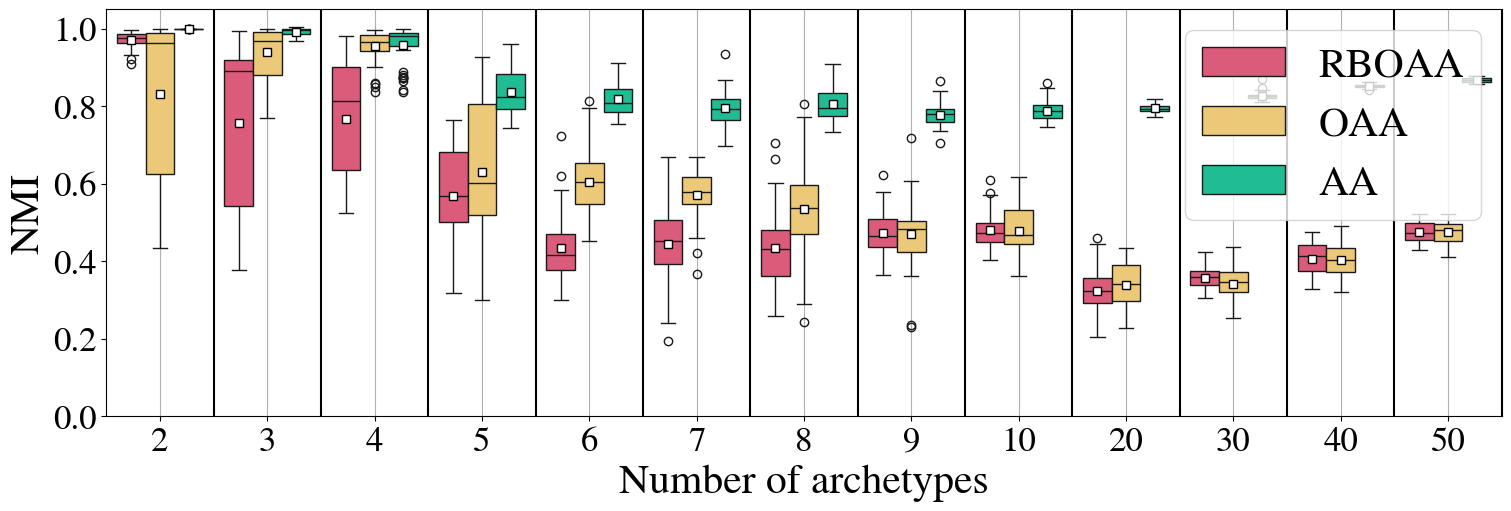

In [13]:
K_list = [2,3,4,5,6,7,8,9,10,20,30,40,50]

plot_NMI_stability('C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/', K_list, repetitions= 10)


plt.savefig("Plots_for_paper/NMI_K_GB.png",dpi=1000)



In [375]:
from colormap import rgb2hex, rgb2hls, hls2rgb
import matplotlib.pyplot as plt

def hex_to_rgb(hex):
     hex = hex.lstrip('#')
     hlen = len(hex)
     return tuple(int(hex[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))

def adjust_color_lightness(r, g, b, factor):
    h, l, s = rgb2hls(r / 255.0, g / 255.0, b / 255.0)
    l = max(min(l * factor, 1.0), 0.0)
    r, g, b = hls2rgb(h, l, s)
    return rgb2hex(int(r * 255), int(g * 255), int(b * 255))

def darken_color(r, g, b, factor=0.1):
    return adjust_color_lightness(r, g, b, 1 - factor)


def plot_archetypal_answers(X,archetypes,likert_text,questions,startColor, type = 'points'):

    def transform_data(data, p):
        likert_counts = pd.DataFrame(columns = range(1,p+1), index = np.arange(data.shape[0]))

        for i in range(data.shape[0]):
            likert_counts.iloc[i,(np.unique(data[i,:], return_counts=True)[0]-1)] = np.unique(data[i,:], return_counts=True)[1]

        likert_counts = likert_counts.fillna(0)

        return likert_counts
    
    likert_counts = transform_data(X, 6)

    fig, ax = plt.subplots(figsize=(8,8))

    ax.imshow(likert_counts.values,aspect='auto', cmap = 'Greys', alpha = 0.8)
    cbar = ax.figure.colorbar(ax.imshow(likert_counts.values,aspect='auto', cmap = 'Greys', alpha = 0.8))

    ax.set_xticks(np.arange(0,6))
    ax.set_xticklabels(likert_text, rotation = 45)

    ax.set_yticks(np.arange(0,likert_counts.shape[0]))
    ax.set_yticklabels(questions)

    y = np.arange(likert_counts.shape[0])

    
    color = []
    color += [startColor]

    ## make off set such that middle archetype is centered
    center = (archetypes.shape[1])//2
    offset = (np.arange(archetypes.shape[1])-center)*0.2




    for i in range(archetypes.shape[1]):
        r, g, b  = hex_to_rgb(color[i])
        color += [darken_color(r, g, b,0.3)]


        if type == 'points':
            ax.scatter(archetypes[:,i]-1+offset[i], y, lw=5., color=color[i],label = f'Archetype {i+1}')
            #ax.scatter(archetypes[:,i]-1, y, lw=5., color=color[i],label = f'Archetype {i+1}')


        else:
            #line = plt.Line2D(archetypes[:,i]-1+offset[i], y,'-o' ,lw=2., color=color[i],label = f'Archetype {i+1}')
            #line.set_clip_on(False)
            #ax.add_line(line)
            ax.plot(archetypes[:,i]-1+offset[i], y,'-o' ,lw=2., color=color[i],label = f'Archetype {i+1}')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)
    

    








In [376]:
with open(f'synthetic_results/1000_results_complex\All_AA_results.json', 'r') as f:
        result = json.load(f)
        df_res = pd.DataFrame(result)

data = GB_res['RBOAA']['K4'][2].X

filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/RBOAA_K=4_rep=2"
file = load_result_obj(filename)
archetypes = np.round(file.X@file.B)

C:\Users\aejew\AppData\Local\Temp\ipykernel_43528\13342780.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  likert_counts = likert_counts.fillna(0)


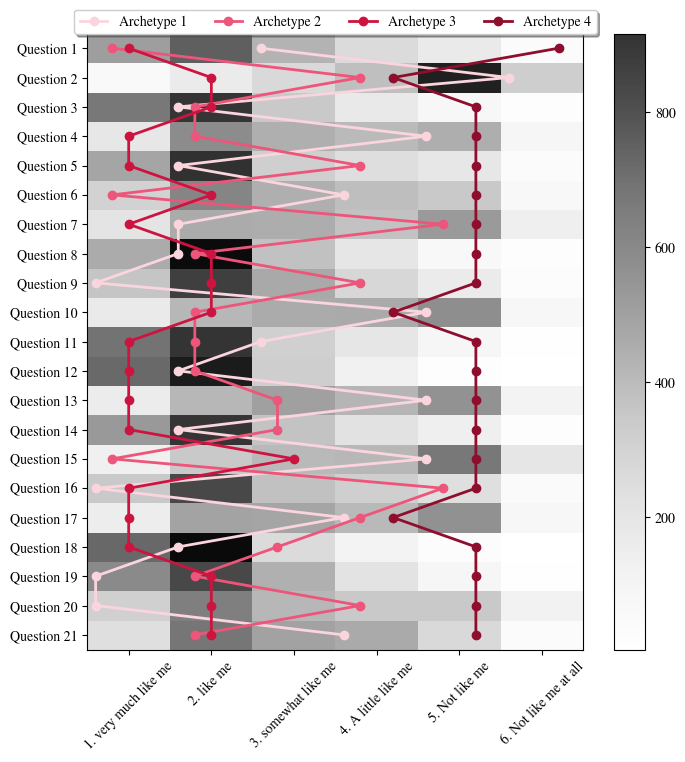

In [377]:
with open(f'synthetic_results/1000_results_complex\All_AA_results.json', 'r') as f:
        result = json.load(f)
        df_res = pd.DataFrame(result)

data = GB_res['RBOAA']['K4'][2].X

filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/RBOAA_K=4_rep=2"
file = load_result_obj(filename)
archetypes = np.round(file.X@file.B)
likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']

questions = [f'Question {i+1}' for i in range(data.shape[0])]

r,g,b = hex_to_rgb(my_pallette['RBOAA'])
new = adjust_color_lightness(r, g, b, 1+0.5)
plot_archetypal_answers(data,archetypes,likert_text,questions,new, type = 'lines')

plt.savefig("Plots_for_paper/Archetypes_RBOAA_GB.png",dpi=1000)

C:\Users\aejew\AppData\Local\Temp\ipykernel_43528\13342780.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  likert_counts = likert_counts.fillna(0)


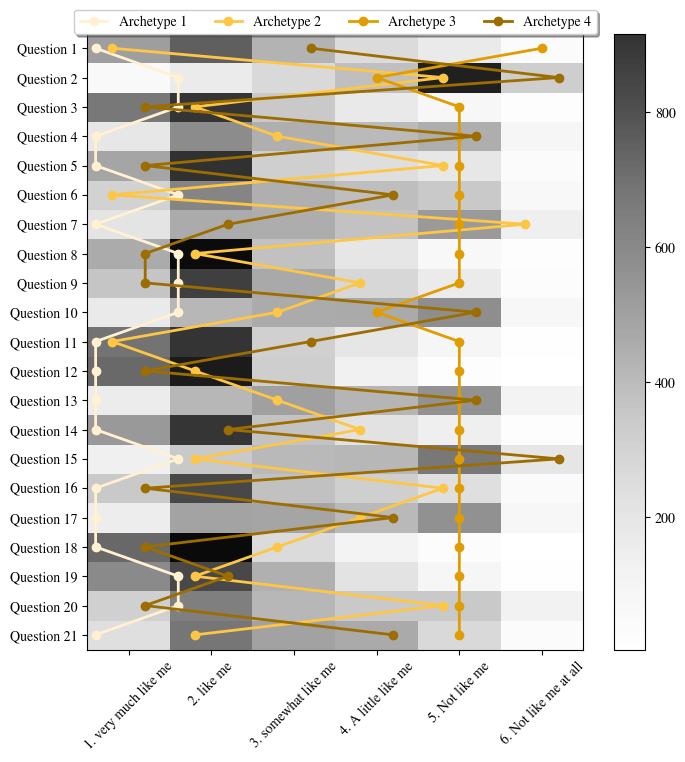

In [378]:

data = GB_res['OAA']['K4'][2].X

filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/OAA_K=4_rep=6"
file = load_result_obj(filename)
archetypes = np.round(file.X@file.B)
likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']

questions = [f'Question {i+1}' for i in range(data.shape[0])]

r,g,b = hex_to_rgb(my_pallette['OAA'])
new = adjust_color_lightness(r, g, b, 1+0.3)
plot_archetypal_answers(file.X,archetypes,likert_text,questions,new, type = 'lines')

plt.savefig("Plots_for_paper/Archetypes_OAA_GB.png",dpi=1000)

C:\Users\aejew\AppData\Local\Temp\ipykernel_43528\13342780.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  likert_counts = likert_counts.fillna(0)


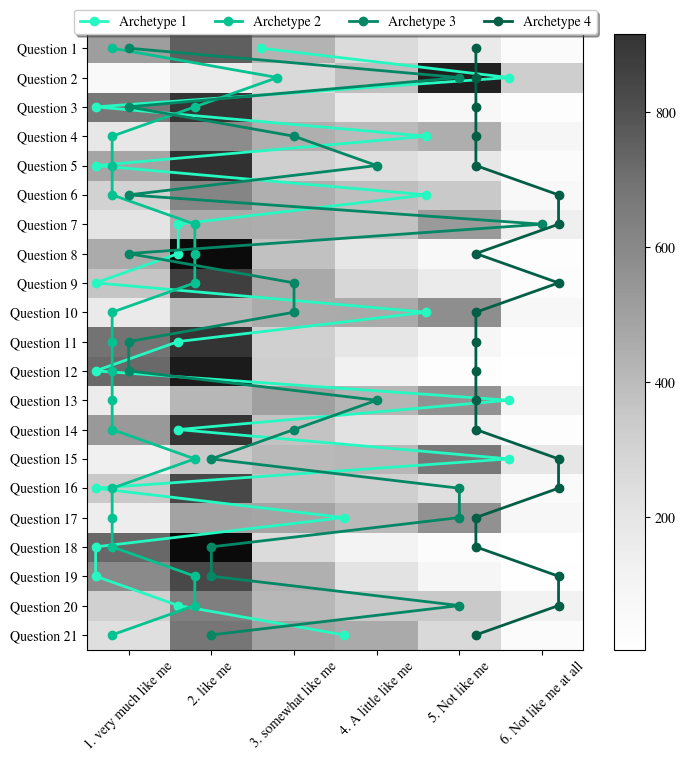

In [379]:

filename = "C:/Users/aejew/Downloads/AA_results/AA_results/ESS8_GB_results/All_Res/CAA_K=4_rep=4"
file = load_result_obj(filename)
archetypes = np.round(file.X@file.B)

likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']
questions = [f'Question {i+1}' for i in range(data.shape[0])]

r,g,b = hex_to_rgb(my_pallette['AA'])
new = adjust_color_lightness(r, g, b, 1+0.3)
plot_archetypal_answers(file.X,archetypes,likert_text,questions,new, type = 'lines')

plt.savefig("Plots_for_paper/Archetypes_AA_GB.png",dpi=1000)

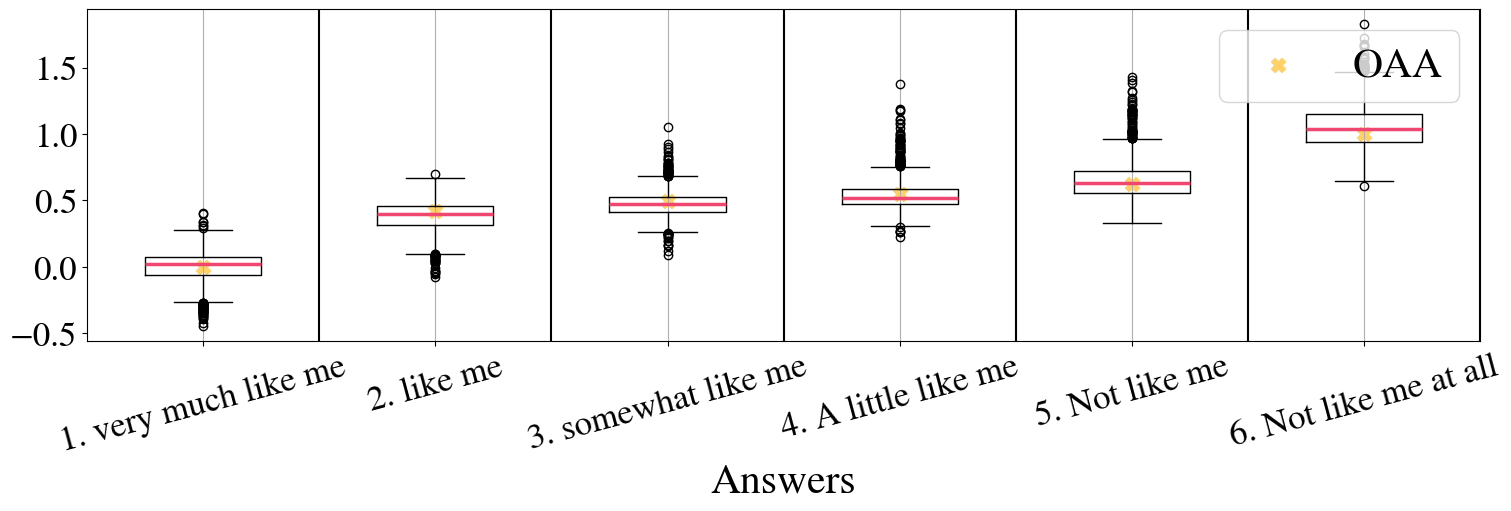

In [380]:
b_OAA = GB_res['OAA']['K4'][6].b

alpha_OAA = []
for j in range(len(b_OAA)-1):
    alpha_OAA += [(b_OAA[j+1]+b_OAA[j])/2]

    
b = GB_res['RBOAA']['K4'][2].b

alpha = np.zeros([X.shape[1],6])

for i in range(X.shape[1]):
    for j in range(b.shape[1]-1):
        alpha[i,j] = (b[i,j+1]+b[i,j])/2


fig, ax = plt.subplots(figsize = (15,5), layout='constrained')
medianprops = dict(linewidth=2.5, color=my_pallette['RBOAA'])
ax.boxplot(alpha,medianprops=medianprops)



ax.scatter(x= ax.get_xticks(), y=alpha_OAA,marker='X',s=100,color = my_pallette['OAA'],label = 'OAA')
ax.xaxis.grid(True, which='major')
[ax.axvline(x+.5,color='k') for x in ax.get_xticks()]
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)    
ax.set_xlabel('Answers', fontsize=30)

likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']
ax.set_xticks(np.arange(1,7))
ax.set_xticklabels(likert_text, rotation = 15)
#ax.set_ylim([0,1.05])
plt.legend(fontsize=30,loc="upper right")
#ax.legend(['First line', 'Second line'])


plt.savefig("Plots_for_paper/RB_GB.png",dpi=1000)



In [381]:
GB_res['RBOAA']['K3'][6].X.shape

(21, 1897)

In [78]:
X_hat = GB_res['RBOAA']['K3'][6].X_hat

In [340]:
alpha

[9.298324584960938e-05,
 0.4168597161769867,
 0.49245548248291016,
 0.5449632406234741,
 0.6233851909637451,
 1.0000202655792236]

In [339]:
b_OAA = GB_res['OAA']['K4'][6].b

alpha_OAA = []
for j in range(len(b_OAA)-1):
    alpha_OAA += [(b_OAA[j+1]+b_OAA[j])/2]

In [212]:
X_hat = GB_res['RBOAA']['K4'][6].X_hat
b = GB_res['RBOAA']['K4'][6].b
sigma = GB_res['RBOAA']['K4'][6].sigma
Xt = GB_res['RBOAA']['K4'][6].X.T


R = GB_res['RBOAA']['K4'][6].X@GB_res['RBOAA']['K4'][6].B@GB_res['RBOAA']['K4'][6].A

R

array([[4.54563547, 2.0709695 , 1.98636972, ..., 2.08130405, 2.04031279,
        3.57087044],
       [4.28921002, 3.9310285 , 4.41195169, ..., 3.49418748, 3.52614552,
        4.40589961],
       [3.8453253 , 2.05485607, 1.95356466, ..., 1.97970722, 1.93286668,
        3.12357003],
       ...,
       [3.96761536, 2.27288498, 2.20504588, ..., 2.08265422, 2.0292401 ,
        3.30265731],
       [4.21290975, 3.06553698, 3.34046071, ..., 2.24650611, 2.18668683,
        3.94569179],
       [4.32399873, 2.75466434, 2.72769782, ..., 2.79719264, 2.78036657,
        3.71753914]])

In [215]:
b.shape

(1897, 7)

In [216]:
Xt.shape

(1897, 21)

In [222]:
R_est

tensor([[ 1.5473,  1.4667, 12.8453,  ...,  0.6057,  0.6033,  0.6645],
        [ 0.8177,  2.9967,  0.9899,  ...,  2.9859,  4.1976,  0.9842],
        [ 2.4220, 10.4412,  2.5549,  ...,  2.5400,  0.2674,  0.0555],
        ...,
        [ 8.0321,  1.1485, 10.2655,  ...,  1.1485,  1.0920,  8.8943],
        [ 0.1284,  0.1579,  0.1295,  ...,  0.1185,  0.1273,  0.1289],
        [ 2.2994,  1.0067,  2.4755,  ...,  2.4656,  1.3964,  4.2932]])

In [220]:
X_hat

tensor([[0.7360, 0.2557, 0.2307,  ..., 0.2671, 0.2587, 0.5422],
        [0.6538, 0.6376, 0.7271,  ..., 0.5616, 0.5687, 0.6943],
        [0.6397, 0.2972, 0.2916,  ..., 0.2571, 0.2476, 0.5094],
        ...,
        [0.5715, 0.3368, 0.3005,  ..., 0.3340, 0.3245, 0.4654],
        [0.6096, 0.4519, 0.4936,  ..., 0.3090, 0.2979, 0.5759],
        [0.6330, 0.4045, 0.3953,  ..., 0.4152, 0.4123, 0.5420]])

In [221]:
GB_res['RBOAA']['K3'][6]

In [209]:
R_est

tensor([[6.8440e-04, 5.3639e-01, 1.4807e+00,  ..., 2.7629e-01, 2.9164e-01,
         1.2400e-02],
        [3.3065e-04, 1.4484e-02, 2.0287e-03,  ..., 5.4476e-02, 4.5632e-01,
         2.0723e-03],
        [2.3597e-02, 8.1500e-01, 8.3609e-01,  ..., 8.0374e-01, 1.2046e-01,
         2.5445e-03],
        ...,
        [2.3083e-03, 1.7829e-01, 5.5964e-01,  ..., 2.5271e-01, 3.3105e-01,
         2.5670e-02],
        [1.2180e-04, 5.8329e-03, 2.1623e-03,  ..., 2.6951e-02, 3.0155e-02,
         3.1872e-04],
        [5.4804e-04, 8.1052e-02, 1.0626e-01,  ..., 8.9052e-02, 1.5025e-01,
         1.4392e-01]])